## Inferential Spatial Statistic using Geographically Weighted Regression (GWR) and Multi-scale Geographically Weighted Regression (MGWR) on Connecticut 'Stop and Search' Data

### 1. This week's overview

In Level 5, you have learned about spatial autocorrelation and spatial regression. This week, we are going to further advance your spatial data analysis skills using Connecticut's traffic 'stop and search data'. 

In the first part of the practical, we will be dealing with data cleaning and basic statistic of our data. In the second part, exploratory data analysis is conducted for extracting meaningful information. The third part is the spatial inferential statistic using correlation and regression. We then continue with a detailed look at conducting the Geographically Weighted Regression (and a multiscale one) to derive local inference based on our model.

### 2. Learning outcomes

By the end of the practicals, you should be able to:
- Extract meaningful information regarding the nature of traffic stop and search in Connecticut, United States, using exploratory data analysis
- Do a correlation and regression especially the geographically weighted regression to derive local statistic of a phenomena
- Create appropriate visualisations for your findings

### 3. Dataset

We are going to use the traffic stop data containing 60 Million Police Stops in the United States. We will focus here on **analysing stop and search cases in Connecticut**. You can download the dataset here, unzip and put it in your local server. 
- https://stacks.stanford.edu/file/druid:py883nd2578/CT-clean.csv.gz

In the United States, there are more than 50,000 traffic stops on a typical day. The potential number of data points for each stop is huge, from the demographics (age, race, gender) of the driver, to the location, time of day, stop reason, stop outcome, car model, and much more. Unfortunately, not every state makes this data available, and those that do often have different standards for which information is reported. Different counties and districts within each state can also be inconstant in how each traffic stop is recorded. So, in June 2017, a team of researchers at Stanford University collected and released an open-source data set of 60 million state police patrol stops from 20 states across the US. 

**In this tutorial, we will walk through how to analyse, visualise and make spatial inference on the Connecticut Stop and Search dataset using Python (mainly PySAL and Geopandas).** 

 The research team at Stanford has managed to gather traffic-stop data from twenty states and has worked to regularize the reporting standards for 11 fields.

- Stop Date
- Stop Time
- Stop Location
- Driver Race
- Driver Gender
- Driver Age
- Stop Reason
- Search Conducted
- Search Type
- Contraband Found
- Stop Outcome

Most states do not have data available for every field, but there is enough overlap between the data sets to provide a solid foundation for some very interesting analysis.

**Note**
If you're interested in the dataset for other states, please see the list below:
- https://stacks.stanford.edu/file/druid:py883nd2578/VT-clean.csv.gz
- https://stacks.stanford.edu/file/druid:py883nd2578/MA-clean.csv.gz
- https://stacks.stanford.edu/file/druid:py883nd2578/WI-clean.csv.gz
- https://stacks.stanford.edu/file/druid:py883nd2578/AZ-clean.csv.gz
- https://stacks.stanford.edu/file/druid:py883nd2578/CO-clean.csv.gz
- https://stacks.stanford.edu/file/druid:py883nd2578/NC-clean.csv.gz
- https://stacks.stanford.edu/file/druid:py883nd2578/WA-clean.csv.gz
- https://stacks.stanford.edu/file/druid:py883nd2578/TX-clean.csv.gz

### 4. Data cleaning

Import the necessary libraries

In [266]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import geopandas as gpd
import pandas as pd
import os
import urllib
import zipfile
import re
from descartes import PolygonPatch
from pysal.model import mgwr
import pysal.lib
import libpysal as ps
from libpysal.weights.contiguity import Queen
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
# conda install mgwr
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap
import warnings
#warnings.filterwarnings("ignore")

In [2]:
pwd


'/home/jovyan'

In [139]:
# Load the dataset and read using pandas
theft = pd.read_csv('/home/jovyan/Theft_Updated.csv', sep=";" ,low_memory=False)
theft.head()

,X,Y,NeighbourhoodName,Location_Type,Premises_Type,Bike_Make,Bike_Speed,Bike_Colour,Cost_of_Bike,Recovered,Stolen,Status,Longitude,Latitude
0,"-8828527,081","5414244,96066256",The Beaches,"Single Home, House (Attach Garage, Cottage, Mo...",House,CA,40,TRQ,730.0,0,1,STOLEN,"-79,30800813","43,66824442"
1,"-8836349,396","5412401,18223108",Church-Yonge Corridor,Other Commercial / Corporate Places (For Profi...,Commercial,TR,24,BLK,700.0,0,1,STOLEN,"-79,37827718","43,65626242"
2,"-8841619,581","5413281,69825284",Palmerston-Little Italy,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,GIANT,8,GRN,500.0,0,1,STOLEN,"-79,42562006","43,66198485"
3,"-8842634,911","5412721,80274905",Dufferin Grove,"Single Home, House (Attach Garage, Cottage, Mo...",House,KO,21,BLU,800.0,0,1,STOLEN,"-79,43474092","43,65834618"
4,"-8838482,023","5412438,63887812",Kensington-Chinatown,"Apartment (Rooming House, Condo)",Apartment,UK,60,YEL,1600.0,0,1,STOLEN,"-79,3974349","43,65650586"


In [117]:
# Later on, we are going to analyse the traffic stop and search
# Let's add some socio-economic data for Connecticut
soceco = pd.read_csv('/home/jovyan/Book6.csv',sep=';',low_memory=False)
soceco.head()

,Neighbourhood,PopDenKM,AvInc,NonImmPer,ImmPer,NoEduPer,BacDegPer,EmploymentRate,UnemploymentRate,TheftRate2016
0,Agincourt North,3929,427037,28.3,71.6,59.9,40.0,50.0,9.8,0.01
1,Agincourt South-Malvern West,3034,278390,32.2,67.7,48.9,51.0,53.2,9.8,0.04
2,Alderwood,2435,168602,66.7,33.2,54.7,45.2,62.4,6.1,0.07
3,Annex,10863,792507,69.7,30.2,14.7,85.2,65.8,6.7,0.06
4,Banbury-Don Mills,2775,493486,50.2,49.7,26.0,73.9,55.6,7.2,0.03


## <a id='Task 2'>Task 1 <a/> - Data Cleaning
    
You might need to do these tasks when dealing with your own dataset - so let's practice!
    
Using pandas, can you do the following tasks:
- List the column labels of the DataFrame
- Count non-NA cells for each column or row
- Fill NA/NaN values using the specified method (in this case, create placeholder using ('N/A', inplace=True)  
- Delete the rows with missing values

In [5]:
# Your code here to list the column labels of the DataFrame
theft.columns

Index(['X', 'Y', 'Occurrence_Year', 'Division', 'City', 'Hood_ID',
       'NeighbourhoodName', 'Location_Type', 'Premises_Type', 'Bike_Make',
       'Bike_Model', 'Bike_Type', 'Bike_Speed', 'Bike_Colour', 'Cost_of_Bike',
       'Status', 'Longitude', 'Latitude', 'ObjectId2'],
      dtype='object')

Let's look out the count of our data. However our search_type_raw and search_type has lots of missing data. So let's drop those for better analysis.

In [140]:
# Your code here to count non-NA cells for each column or row
theft.count()

X                    3858
Y                    3858
NeighbourhoodName    3858
Location_Type        3858
Premises_Type        3858
Bike_Make            3858
Bike_Speed           3858
Bike_Colour          3524
Cost_of_Bike         3564
Recovered            3858
Stolen               3858
Status               3858
Longitude            3858
Latitude             3858
dtype: int64

In [141]:
# Your code here to fill missing search type values with placeholder
theft['Bike_Colour'].fillna('N/A', inplace=True)
theft['Bike_Colour'].fillna('N/A', inplace=True)

In [142]:
# Write your own code to delete the rows with missing values
theft.dropna(inplace=True)

Upon checking the data after dropping the row with missing values, we should have a more consistent dataset with similar counts for each variable.

In [143]:
# Re-check our count data after we drop the rows with missing values
theft.count()

X                    3564
Y                    3564
NeighbourhoodName    3564
Location_Type        3564
Premises_Type        3564
Bike_Make            3564
Bike_Speed           3564
Bike_Colour          3564
Cost_of_Bike         3564
Recovered            3564
Stolen               3564
Status               3564
Longitude            3564
Latitude             3564
dtype: int64

We can continue on investigating our data and make sense of our data distribution by checking the count of each variable.

In [144]:
# Count the data based on the town's name
theft['Cost_of_Bike'].value_counts()

500.0     315
1000.0    221
600.0     217
800.0     160
700.0     156
         ... 
529.0       1
1118.0      1
585.0       1
735.0       1
903.0       1
Name: Cost_of_Bike, Length: 392, dtype: int64

In [127]:
# Count the data based on whether or not search is conducted
theft['Status'].value_counts()

STOLEN       3510
RECOVERED      28
UNKNOWN        26
Name: Status, dtype: int64

In [128]:
# Count the data based on violation
theft['Location_Type'].value_counts()

Streets, Roads, Highways (Bicycle Path, Private Road)                     722
Apartment (Rooming House, Condo)                                          691
Single Home, House (Attach Garage, Cottage, Mobile)                       567
Other Commercial / Corporate Places (For Profit, Warehouse, Corp. Bldg    376
Parking Lots (Apt., Commercial Or Non-Commercial)                         322
Private Property Structure (Pool, Shed, Detached Garage)                  287
Universities / Colleges                                                   120
Other Non Commercial / Corporate Places (Non-Profit, Gov'T, Firehall)      59
Open Areas (Lakes, Parks, Rivers)                                          58
Schools During Supervised Activity                                         51
Bar / Restaurant                                                           50
Ttc Subway Station                                                         47
Hospital / Institutions / Medical Facilities (Clinic, Dentist, M

The downside of the data set is that there is no agreed standard of violation classification, thus we see here there are many duplicates in terms of the classification. To avoid too much repetition, let's just cut the type of violation where value count is less than 1000 for simplicity purposes.

In [145]:
# Create new datafarme 
value_counts = theft['Premises_Type'].value_counts()

# Simplify our data and remove the values where the count is less than 1000
to_remove = value_counts[value_counts <= 10].index

In [146]:
# Keep rows where the city column is not in to_remove
theft = theft[~theft.Premises_Type.isin(to_remove)]

## <a id='Task 2'>Task 2 <a/> - Understanding the dataset
    
Using pandas, can you do the following tasks:
- Count the data based on various number of violations
- Count the data based on driver gender
- Count the data based on driver race

In [147]:
# We have now clean the data and only include violation with counts of more than 1000
# Can you recheck and count the data based on various number of violations?
theft['Premises_Type'].value_counts()

Outside        1103
Apartment       691
House           567
Commercial      485
Other           439
Educational     204
Transit          75
Name: Premises_Type, dtype: int64

In [20]:
# When we try to understand our data, sometimes we need to check things repeatedly
theft['Status'].value_counts()

STOLEN       3510
RECOVERED      28
UNKNOWN        26
Name: Status, dtype: int64

In [22]:
# Count the data based on the driver's gender 
theft['Bike_Colour'].value_counts()

BLK       1007
WHI        310
GRY        307
BLU        301
N/A        279
          ... 
YELWHI       1
DBLDGR       1
LGRBLU       1
SILGRN       1
GRNDGR       1
Name: Bike_Colour, Length: 110, dtype: int64

In [23]:
# Count the data based on the driver's race
theft['Premises_Type'].value_counts()

Outside        1103
Apartment       691
House           567
Commercial      485
Other           439
Educational     204
Transit          75
Name: Premises_Type, dtype: int64

Great, now our data is ready fof further investigation. In the next section, we will extract more information based on our data. Firstly, we are going to try to investigate if racial bias occurs in Connecticut stop and search by examining if certain race is being stopped more frequently than others, and how many of those stops end up in arrests. Secondly, we're going to calculate the hit rate, if a search ends up in contrabands found. 

### 5. Exploratory spatial data analysis

There are three things that we are going to do in this section:
1. We will see which race and in what age a driver is more likely to be stopped in traffic by the police.
2. We will examine the outcome of the stop and search based on the race and the reason the driver is being stopped, and see if the stop and search results in arrests.
3. We will explore whether a stop leads to a search and the rate in which contrabands are found.

Ok, let's start.

### 5.1 which race and in what age a driver is more likely to be stopped in traffic by the police?

In this subsection, we will examine if racial bias is indeed present when a police in Conneticut stops a driver by calculating the density of stop and search based on driver's age and race. 

In [131]:
theft.dtypes

X                 object
Y                 object
Location_Type     object
Premises_Type     object
Bike_Make         object
Bike_Speed         int64
Bike_Colour       object
Cost_of_Bike     float64
Recovered          int64
Stolen             int64
Status            object
Longitude         object
Latitude          object
dtype: object

In [24]:
# Include all the race except for 'other'

theft1 = theft[theft[''] != 'NULL']

TypeError: no numeric data to plot

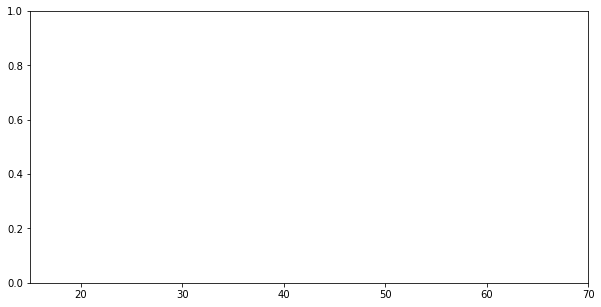

In [148]:
# Plot the graph of driver race and age against the density of stop and search
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlim(15, 70)
for race in theft['Bike_Speed'].unique():
    s = theft1[theft1['Bike_Speed'] == race]['Cost_of_Bike']
    s.plot.kde(ax=ax, label=race)
ax.legend()

What information can you derive from the plot? We can see from all race, a driver between the age of 20 and 30 is more likely to be stopped in traffic for a stop and search by the police. This number drops with age. Black and Hispanic rate have higher stop and search density compared to their Asian and White peer.

### 5.2 Stop and search outcome analysis

When stopping a driver, a stop and search can result in different outcomes including verbal and written warnings, summons, as well as arrests. We can compute the rate of these outcomes by building this function below:

In [149]:
theft.head()

,X,Y,NeighbourhoodName,Location_Type,Premises_Type,Bike_Make,Bike_Speed,Bike_Colour,Cost_of_Bike,Recovered,Stolen,Status,Longitude,Latitude
0,"-8828527,081","5414244,96066256",The Beaches,"Single Home, House (Attach Garage, Cottage, Mo...",House,CA,40,TRQ,730.0,0,1,STOLEN,"-79,30800813","43,66824442"
1,"-8836349,396","5412401,18223108",Church-Yonge Corridor,Other Commercial / Corporate Places (For Profi...,Commercial,TR,24,BLK,700.0,0,1,STOLEN,"-79,37827718","43,65626242"
2,"-8841619,581","5413281,69825284",Palmerston-Little Italy,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,GIANT,8,GRN,500.0,0,1,STOLEN,"-79,42562006","43,66198485"
3,"-8842634,911","5412721,80274905",Dufferin Grove,"Single Home, House (Attach Garage, Cottage, Mo...",House,KO,21,BLU,800.0,0,1,STOLEN,"-79,43474092","43,65834618"
4,"-8838482,023","5412438,63887812",Kensington-Chinatown,"Apartment (Rooming House, Condo)",Apartment,UK,60,YEL,1600.0,0,1,STOLEN,"-79,3974349","43,65650586"


In [150]:
def outcome_stats(theft):
    """Compute statistics regarding the relative quanties of arrests, warnings, and citations"""
    n_total = len(theft)
    n_stolen = len(theft[theft['Status'] == 'STOLEN'])
    n_recovered = len(theft[theft['Status'] == 'RECOVERED'])
    n_house = len(theft[theft['Premises_Type'] == 'House'])
    n_outside = len(theft[theft['Premises_Type'] == 'Outside'])
    stolen_rate = n_stolen / n_total
    
    return(pd.Series(data = { 
        'n_total': n_total,
        'n_stolen': n_stolen,
        'n_recovered': n_recovered,
        'n_house' : n_house,
        'n_outside': n_outside,
        'stolen_rate': stolen_rate
    }))

In [136]:
stolen = theft[theft.Status == 'STOLEN']

In [151]:
n_stolen= stolen
print(n_stolen)

                 X                 Y  \
0     -8828527,081  5414244,96066256   
1     -8836349,396  5412401,18223108   
2     -8841619,581  5413281,69825284   
3     -8842634,911  5412721,80274905   
4     -8838482,023  5412438,63887812   
...            ...               ...   
3853  -8840862,846  5410545,92192276   
3854  -8840199,499  5429805,99130591   
3855  -8837028,273  5412562,03424745   
3856  -8842801,218  5414288,68061999   
3857  -8833995,315  5411565,69875099   

                                          Location_Type Premises_Type  \
0     Single Home, House (Attach Garage, Cottage, Mo...         House   
1     Other Commercial / Corporate Places (For Profi...    Commercial   
2     Streets, Roads, Highways (Bicycle Path, Privat...       Outside   
3     Single Home, House (Attach Garage, Cottage, Mo...         House   
4                      Apartment (Rooming House, Condo)     Apartment   
...                                                 ...           ...   
3853  St

## <a id='Task 2'>Task 3 <a/> - Exploring the dataset

Can you count based on the function above, how many stop and search ends up in:
- verbal warnings
- written warnings
- summons
- arrests

Which one is the highest and lowest outcome?

In [152]:
# Statistics of stop and search outcome
outcome_stats(theft)

n_total        3564.000000
n_stolen       3510.000000
n_recovered      28.000000
n_house         567.000000
n_outside      1103.000000
stolen_rate       0.984848
dtype: float64

In [153]:
# We can also group the outcome based on the driver race and violation
theft.groupby(['NeighbourhoodName']).apply(outcome_stats)

,n_total,n_stolen,n_recovered,n_house,n_outside,stolen_rate
NeighbourhoodName,,,,,,
Agincourt North,2.0,1.0,1.0,1.0,1.0,0.500000
Agincourt South-Malvern West,2.0,2.0,0.0,0.0,0.0,1.000000
Alderwood,2.0,2.0,0.0,2.0,0.0,1.000000
Annex,125.0,125.0,0.0,21.0,45.0,1.000000
Banbury-Don Mills,4.0,4.0,0.0,2.0,0.0,1.000000
...,...,...,...,...,...,...
Wychwood,37.0,35.0,0.0,11.0,11.0,0.945946
Yonge-Eglinton,17.0,17.0,0.0,5.0,3.0,1.000000
Yonge-St.Clair,15.0,15.0,0.0,3.0,6.0,1.000000


<AxesSubplot:title={'center':'Arrest Rate By Race and Violation'}, xlabel='None,Status'>

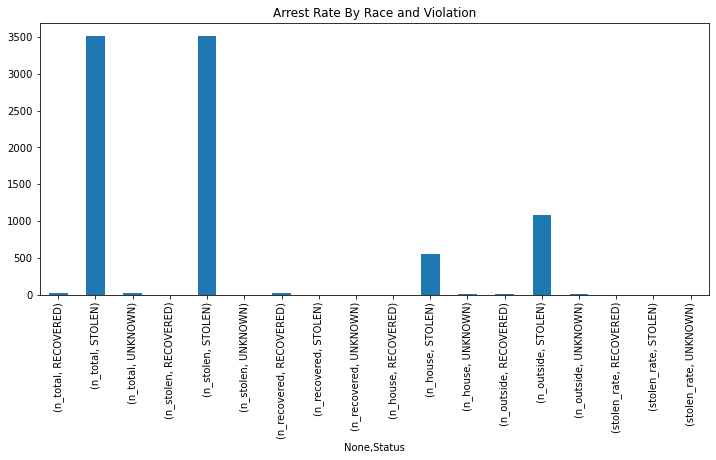

In [154]:
# Let's visualise the violation based on the driver's race and see how many of these result in arrests
theft_stats = theft.groupby(['Status']).apply(outcome_stats).unstack()
theft_stats.plot.bar(y='Status', title='Arrest Rate By Race and Violation', figsize=(12,5))

Based on the graph, the Black race has the highest rate of arrests (0.10) and they are most likely to be stopped due to license check instead of other traffic violations. This is followed by Hispanic with 0.09 arrests rate when stopped for license check.

So, do you think racial bias is present according to our dataset?

### 5.3 Stop and search hit rate

When stopping a driver, police can conduct a search, and some of this search lead to contrabands found (hit). We can examine the proportion of searches that result in contrabands found by building this function below:

In [24]:
def search_stats(df):
    """Compute the search rate and hit rate"""
    search_conducted = df['search_conducted']
    contraband_found = df['contraband_found']
    n_stops     = len(search_conducted)
    n_searches  = sum(search_conducted)
    n_hits      = sum(contraband_found)
    
    # Filter out counties with too few stops
    if (n_stops) < 50:
        search_rate = None
    else:
        search_rate = n_searches / n_stops
    
    # Filter out counties with too few searches
    if (n_searches) < 5:
        hit_rate = None
    else:
        hit_rate = n_hits / n_searches
    
    return(pd.Series(data = { 
        'n_stops': n_stops,
        'n_searches': n_searches,
        'n_hits': n_hits,
        'search_rate': search_rate,
        'hit_rate': hit_rate
    }))

In [25]:
# Let's get the search and hit rates
search_stats(df_ct)

n_stops        309120.000000
n_searches       5187.000000
n_hits           1770.000000
search_rate         0.016780
hit_rate            0.341238
dtype: float64

In [26]:
# Get the outcome stats per-town in connecticut
town_stop_search = df_ct.groupby(['Location_Raw']).apply(outcome_stats)
town_stop_search.head()

,n_total,n_verbal_warnings,n_written_warnings,n_summons,n_arrests,arrest_rate
Location_Raw,,,,,,
Andover,1086.0,169.0,48.0,27.0,14.0,0.012891
Ansonia,169.0,41.0,8.0,5.0,5.0,0.029586
Ashford,1217.0,177.0,112.0,30.0,22.0,0.018077
Avon,23.0,7.0,6.0,1.0,0.0,0.000000
Barkhamsted,745.0,59.0,282.0,60.0,13.0,0.017450


In [27]:
# Group the search and hit rates according to the driver's race
race_outcome = df_ct.groupby('driver_race').apply(search_stats)
race_outcome.head()

,n_stops,n_searches,n_hits,search_rate,hit_rate
driver_race,,,,,
Asian,5854.0,25.0,10.0,0.004271,0.400000
Black,36408.0,1190.0,339.0,0.032685,0.284874
Hispanic,30216.0,933.0,271.0,0.030878,0.290461
Other,1707.0,13.0,0.0,0.007616,0.000000
White,234935.0,3026.0,1150.0,0.012880,0.380040


What is your conclusion based on these findings?

### 6. Spatial inferential statistic

For our spatial inferential statistic, we will examine the stop and search data against the socio-economic dataset from Connecticut open data website. Three variables are chosen in particular: median household income, median house rent price and crime index data. We will try to make inferences of the relationship between the socio-economic data and the stop and search dataset. 

In [155]:
# First, let's merge our two dataset using pandas merge function based on the same column values (Town and Location_Ra)
gwr_data = pd.merge(soceco, theft, left_on='Neighbourhood', right_on='NeighbourhoodName')

gwr_data.count()

Neighbourhood        3340
PopDenKM             3340
AvInc                3340
NonImmPer            3340
ImmPer               3340
NoEduPer             3340
BacDegPer            3340
EmploymentRate       3340
UnemploymentRate     3340
TheftRate2016        3340
X                    3340
Y                    3340
NeighbourhoodName    3340
Location_Type        3340
Premises_Type        3340
Bike_Make            3340
Bike_Speed           3340
Bike_Colour          3340
Cost_of_Bike         3340
Recovered            3340
Stolen               3340
Status               3340
Longitude            3340
Latitude             3340
dtype: int64

In [156]:
gwr_data.dropna(inplace=True)

In [154]:
gwr_data.rename(columns={'Unemplyment': 'Unemployment'}, inplace=True)

In [157]:
gwr_data.count()

Neighbourhood        3340
PopDenKM             3340
AvInc                3340
NonImmPer            3340
ImmPer               3340
NoEduPer             3340
BacDegPer            3340
EmploymentRate       3340
UnemploymentRate     3340
TheftRate2016        3340
X                    3340
Y                    3340
NeighbourhoodName    3340
Location_Type        3340
Premises_Type        3340
Bike_Make            3340
Bike_Speed           3340
Bike_Colour          3340
Cost_of_Bike         3340
Recovered            3340
Stolen               3340
Status               3340
Longitude            3340
Latitude             3340
dtype: int64

In [43]:
gwr_data.dropna(inplace=True)

### 6.1 Correlation

A correlation matrix is a table showing correlation coefficients between variables used to summarize data. The correlation coeffiecient (r) indicates association, where +1 is perfect positive relationship and -1 is perfect negative relationship. It is useful to examine the relationships between variables fairly quickly.

Pandas `dataframe.corr()` is used to find the pairwise correlation of all columns in the dataframe. Any na values are automatically excluded. For any non-numeric data type columns in the dataframe it is ignored.

## <a id='Task 2'>Task 4 <a/>
- Can you create a correlation matrix, first you need to drop unnecessary columns

In [158]:
# Creating a correlation matrix
# Let's clean our data and drop X and Y information
data = gwr_data.drop(['X','Y'], axis=1)


In [159]:
# Create a correlation matrix here using pandas
corr= data.corr()

In [160]:
# style it
corr.style.background_gradient(cmap='coolwarm')



,PopDenKM,AvInc,NonImmPer,ImmPer,NoEduPer,BacDegPer,EmploymentRate,UnemploymentRate,TheftRate2016,Bike_Speed,Cost_of_Bike,Recovered,Stolen
PopDenKM,1.000000,-0.184993,-0.081248,0.081128,-0.390010,0.389982,0.133261,0.168847,0.487340,-0.003630,-0.015225,-0.049228,0.067685
AvInc,-0.184993,1.000000,0.287727,-0.287630,-0.349122,0.349057,0.251524,-0.394149,-0.029868,0.023885,0.088882,0.016121,-0.002773
NonImmPer,-0.081248,0.287727,1.000000,-0.999999,-0.228915,0.228895,0.570153,-0.654156,-0.230946,-0.050513,0.107938,0.015724,-0.024992
ImmPer,0.081128,-0.287630,-0.999999,1.000000,0.228929,-0.228910,-0.570293,0.654191,0.230805,0.050568,-0.107899,-0.015750,0.024966
NoEduPer,-0.390010,-0.349122,-0.228915,0.228929,1.000000,-1.000000,-0.474451,0.297623,-0.282339,-0.038118,-0.044186,0.036741,-0.041658
BacDegPer,0.389982,0.349057,0.228895,-0.228910,-1.000000,1.000000,0.474617,-0.297722,0.282362,0.038119,0.044175,-0.036728,0.041650
EmploymentRate,0.133261,0.251524,0.570153,-0.570293,-0.474451,0.474617,1.000000,-0.829865,-0.203587,-0.009623,0.025327,0.004088,0.009175
UnemploymentRate,0.168847,-0.394149,-0.654156,0.654191,0.297623,-0.297722,-0.829865,1.000000,0.429733,-0.005735,-0.055614,-0.018125,0.016954
TheftRate2016,0.487340,-0.029868,-0.230946,0.230805,-0.282339,0.282362,-0.203587,0.429733,1.000000,-0.022229,-0.008536,-0.019419,0.037413
Bike_Speed,-0.003630,0.023885,-0.050513,0.050568,-0.038118,0.038119,-0.009623,-0.005735,-0.022229,1.000000,0.016034,-0.000760,0.018737


In spatial analysis workflows it is often important and necessary to asses the relationships of neighbouring polygons. libpysal and splot can help you to inspect if two neighbouring polygons share an edge or not. This visualisation depicts the spatial weights network, a network of connections of the centroid of each polygon to the centroid of its neighbour. 

We can start to see the positive and negative associations between variables. For example, crime index has 0.2 negative association with household income where higher income in an area is associated with lower crime. This makes sense.

***Can you examine the relationship between crime index and total stop and search? why this might be?***

We have learned that in spatial analysis, we often need to make spatial inferences locally where the global model is not suitable. Here, we will explore local model to explain stop and search phenomena. Let's start with conducting OLS and the geographically weighted regression for Connecticut township to determine if number of arrests from stop and search is associated with the socio economic profile of each township.

### 6.2 Regression: Ordinary Least Squares (Global Model) and Geographically Weighted Regression - GWR (Local Model)
Simple linear regression, the most used technique in geographical analysis, assumes changes across space to be universal, which is not always the case in the spatial context. Variations across geographical space, known as spatial non-stationarity, might be lost when using simple global fitting methods such as Ordinary Least Squares (OLS). Therefore, geographically weighted regression (GWR), provides an alternative method to analyse and model the complex spatial variations in local parameter estimates. The developed method extends the traditional linear regression technique to incorporate spatial heterogeneity in different regions by allowing the parameter estimate to vary locally.

In this section, we will compare the summary statistic as a result of the global OLS (Ordinary Least Squares) model and the Geographically Weighted Regression.

### 6.2.1 Ordinary Least Squares (OLS)

Before conduction OLS, first we need to check if our data suffers from multicollinearity. Multicollinearity occurs when independent variables in a regression model are correlated. This correlation is a problem because independent variables should be independent. If the degree of correlation between variables is high enough, it can cause problems when you fit the model and interpret the results.

A variance inflation factor(VIF) detects multicollinearity in regression analysis. Multicollinearity is when there’s correlation between predictors (i.e. independent variables) in a model; it’s presence can adversely affect your regression results. The VIF estimates how much the variance of a regression coefficient is inflated due to multicollinearity in the model.

Variance inflation factors range from 1 upwards. The numerical value for VIF tells you (in decimal form) what percentage the variance (i.e. the standard error squared) is inflated for each coefficient. For example, a VIF of 1.9 tells you that the variance of a particular coefficient is 90% bigger than what you would expect if there was no multicollinearity — if there was no correlation with other predictors.
A rule of thumb for interpreting the variance inflation factor:

- 1 = not correlated.
- Between 1 and 5 = moderately correlated.
- Greater than 5 = highly correlated.

Let's check our data's VIF

In [161]:
soceco.tail()

,Neighbourhood,PopDenKM,AvInc,NonImmPer,ImmPer,NoEduPer,BacDegPer,EmploymentRate,UnemploymentRate,TheftRate2016
136,Wychwood,8541,239484,66.2,33.7,40.1,59.8,65.6,5.2,0.01
137,Yonge-Eglinton,7162,222648,71.7,28.2,13.6,86.3,68.2,6.9,0.04
138,Yonge-St.Clair,10708,541217,69.9,30.0,11.0,88.9,65.2,5.9,0.12
139,York University Heights,2086,302358,39.7,60.2,56.7,43.2,56.3,10.7,0.14
140,Yorkdale-Glen Park,2451,213860,46.7,53.2,68.3,31.6,55.3,8.0,0.01


In [162]:

gwr_data.dtypes

Neighbourhood         object
PopDenKM               int64
AvInc                  int64
NonImmPer            float64
ImmPer               float64
NoEduPer             float64
BacDegPer            float64
EmploymentRate       float64
UnemploymentRate     float64
TheftRate2016        float64
X                     object
Y                     object
NeighbourhoodName     object
Location_Type         object
Premises_Type         object
Bike_Make             object
Bike_Speed             int64
Bike_Colour           object
Cost_of_Bike         float64
Recovered              int64
Stolen                 int64
Status                object
Longitude             object
Latitude              object
dtype: object

In [225]:
#find design matrix for linear regression model using 'rating' as response variable 
y, X = dmatrices('UnemploymentRate ~ NoEduPer +AvInc+Recovered+Stolen', data=gwr_data, return_type='dataframe')


In [226]:
#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

In [227]:
#view VIF for each explanatory variable 
vif

,VIF,variable
0,142.948950,Intercept
1,1.141572,NoEduPer
2,1.139914,AvInc
3,1.947371,Recovered
4,1.946928,Stolen


We can see that none of our independent data has VIF value more than 5. We're good! Don't worry about the intercept value - a large vif in the constant only indicates that the (slope) explanatory variables have also a large constant component. 

## <a id='Task 2'>Task 5 <a/>
In last term's practical, you learned how to do an OLS regression using PySAL and statsmodel. Can you try it again using our data?

In [228]:
# First, you need to prepare the dataset so it can be processed in pysal
crime = gwr_data['TheftRate2016']

In [229]:
gwr_data.dtypes

Neighbourhood         object
PopDenKM               int64
AvInc                  int64
NonImmPer            float64
ImmPer               float64
NoEduPer             float64
BacDegPer            float64
EmploymentRate       float64
UnemploymentRate     float64
TheftRate2016        float64
X                     object
Y                     object
NeighbourhoodName     object
Location_Type         object
Premises_Type         object
Bike_Make             object
Bike_Speed             int64
Bike_Colour           object
Cost_of_Bike         float64
Recovered              int64
Stolen                 int64
Status                object
Longitude             object
Latitude              object
dtype: object

In [247]:
# OLS class requires data to be passed as numpy array
y = np.array(crime)
# PySAL requires your dependent variable to be nx1 numpy array
y.shape = (len(crime),1)

In [248]:
# Now prepare your independent variables
X = []
X.append(gwr_data['AvInc'])
X.append(gwr_data['NoEduPer'])
X.append(gwr_data['Cost_of_Bike'])
X.append(gwr_data['UnemploymentRate'])

In [249]:
# PySAL requires your independent variable to be a 2D nxj numpy array where j is the number of independent variables
X=np.array(X).T

In [250]:
# Check if your independent variables are in the right format
print(X.shape)

(3340, 4)


In [251]:
# Your code for OLS regression here using pysal.model.spreg.OLS
ols = pysal.model.spreg.OLS(y, X, name_y='TheftRate2016',\
          name_x=['AvInc','NoEduPer','Cost_of_Bike', 'UnemploymentRate'],\
          name_ds='Toronto', white_test=True)
print(ols.summary)                     

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     Toronto
Weights matrix      :        None
Dependent Variable  :TheftRate2016                Number of Observations:        3340
Mean dependent var  :      0.0361                Number of Variables   :           5
S.D. dependent var  :      0.0359                Degrees of Freedom    :        3335
R-squared           :      0.3709
Adjusted R-squared  :      0.3701
Sum squared residual:       2.712                F-statistic           :    491.5449
Sigma-square        :       0.001                Prob(F-statistic)     :           0
S.E. of regression  :       0.029                Log likelihood        :    7144.745
Sigma-square ML     :       0.001                Akaike info criterion :  -14279.489
S.E of regression ML:      0.0285                Schwarz criterion     :  -14248.921

----------------------------------------------------------------------------

In [252]:
# We can do this using statsmodel as well, just as a comparison

x = ['AvInc','NoEduPer','Cost_of_Bike', 'UnemploymentRate'] # define input/independant variables
X = data.loc[:, x].dropna()
X = sm.add_constant(X)
y = np.array(data['TheftRate2016']) # define output/dependant variable

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     491.5
Date:                Fri, 13 Jan 2023   Prob (F-statistic):               0.00
Time:                        13:44:41   Log-Likelihood:                 7144.7
No. Observations:                3340   AIC:                        -1.428e+04
Df Residuals:                    3335   BIC:                        -1.425e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0299      0.003  

The Durbin Watson (DW) statistic is a test for autocorrelation in the residuals from a statistical regression analysis. The Durbin-Watson statistic will always have a value between 0 and 4.
Values from 0 to less than 2 indicate positive autocorrelation and values from from 2 to 4 indicate negative autocorrelation. Our Durbin Watson indicates a value of 1.9 - thus there is a positive autocorrelation in our residuals, meaning that we need to conduct spatial regression!

### 6.2.2 Geographically Weighted Regression (GWR)

Now, let's try and compare the results of our OLS with GWR model. The summary of GWR model will also contain OLS automatically, but they are not as comprehensive as our previous one so it's good just to have more information.

In [265]:
# Get GWR model information

np.array(gwr_data['EmploymentRate'], dtype=np.float32)

gwr_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3340 entries, 0 to 3339
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Neighbourhood      3340 non-null   object 
 1   PopDenKM           3340 non-null   int64  
 2   AvInc              3340 non-null   int64  
 3   NonImmPer          3340 non-null   float64
 4   ImmPer             3340 non-null   float64
 5   NoEduPer           3340 non-null   float64
 6   BacDegPer          3340 non-null   float64
 7   EmploymentRate     3340 non-null   float64
 8   UnemploymentRate   3340 non-null   float64
 9   TheftRate2016      3340 non-null   float64
 10  X                  3340 non-null   object 
 11  Y                  3340 non-null   object 
 12  NeighbourhoodName  3340 non-null   object 
 13  Location_Type      3340 non-null   object 
 14  Premises_Type      3340 non-null   object 
 15  Bike_Make          3340 non-null   object 
 16  Bike_Speed         3340 

In [285]:
gwr_data

,Neighbourhood,PopDenKM,AvInc,NonImmPer,ImmPer,NoEduPer,BacDegPer,EmploymentRate,UnemploymentRate,TheftRate2016,...,Premises_Type,Bike_Make,Bike_Speed,Bike_Colour,Cost_of_Bike,Recovered,Stolen,Status,Longitude,Latitude
0,Agincourt North,3929,427037,28.3,71.6,59.9,40.0,50.0,9.8,0.01,...,Outside,SCOTT,18,GRY,500.0,1,0,RECOVERED,"-79,26646318","43,80802563"
1,Agincourt North,3929,427037,28.3,71.6,59.9,40.0,50.0,9.8,0.01,...,House,UK,29,RED,1000.0,0,1,STOLEN,"-79,28060753","43,80644999"
2,Agincourt South-Malvern West,3034,278390,32.2,67.7,48.9,51.0,53.2,9.8,0.04,...,Apartment,CC,18,YEL,200.0,0,1,STOLEN,"-79,23778163","43,79151019"
3,Agincourt South-Malvern West,3034,278390,32.2,67.7,48.9,51.0,53.2,9.8,0.04,...,Apartment,CC,24,WHI,660.0,0,1,STOLEN,"-79,23778163","43,79151019"
4,Alderwood,2435,168602,66.7,33.2,54.7,45.2,62.4,6.1,0.07,...,House,OTHER,18,WHI,1000.0,0,1,STOLEN,"-79,55327892","43,60656289"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,Yorkdale-Glen Park,2451,213860,46.7,53.2,68.3,31.6,55.3,8.0,0.01,...,Commercial,SP,21,BLK,150.0,0,1,STOLEN,"-79,44893304","43,71749643"
3336,Yorkdale-Glen Park,2451,213860,46.7,53.2,68.3,31.6,55.3,8.0,0.01,...,Commercial,OT,21,BLK,200.0,0,1,STOLEN,"-79,45130961","43,72364999"
3337,Yorkdale-Glen Park,2451,213860,46.7,53.2,68.3,31.6,55.3,8.0,0.01,...,Transit,CCM,18,YEL,200.0,0,1,STOLEN,"-79,44598667","43,72478043"
3338,Yorkdale-Glen Park,2451,213860,46.7,53.2,68.3,31.6,55.3,8.0,0.01,...,Commercial,SU,21,BLK,150.0,0,1,STOLEN,"-79,44893304","43,71749643"


In [286]:
#Prepare dataset inputs
g_y = gwr_data['TheftRate2016'].values.reshape((-1,1))
g_X = gwr_data[['AvInc','NoEduPer','Cost_of_Bike', 'UnemploymentRate']].values
u = gwr_data['X']
v = gwr_data['Y']
g_coords = list(zip(u,v))




In [287]:
bw = mgwr.sel_bw.Sel_BW(g_coords, # a collection of n sets of x and y coordinates
                     g_y, # dependent variable
                     g_X,
                        fixed=False,
                        spherical=True# independent variables
                     ) # bandwidth value  ( we use N nearest neighbours)

In [276]:
from mgwr.sel_bw import Sel_BW
from mgwr.gwr import GWR

In [288]:
# Calculate the optimum bandwidth for our local regression?
bw.search()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mNo implementation of function Function(<built-in function sub>) found for signature:
 
 >>> sub(array([unichr x 16], 1d, A), [unichr x 16])
 
There are 12 candidate implementations:
[1m    - Of which 10 did not match due to:
    Overload of function 'sub': File: <numerous>: Line N/A.
      With argument(s): '(array([unichr x 16], 1d, A), [unichr x 16])':[0m
[1m     No match.[0m
[1m    - Of which 2 did not match due to:
    Operator Overload in function 'sub': File: unknown: Line unknown.
      With argument(s): '(array([unichr x 16], 1d, A), [unichr x 16])':[0m
[1m     No match for registered cases:
      * (int64, int64) -> int64
      * (int64, uint64) -> int64
      * (uint64, int64) -> int64
      * (uint64, uint64) -> uint64
      * (float32, float32) -> float32
      * (float64, float64) -> float64
      * (complex64, complex64) -> complex64
      * (complex128, complex128) -> complex128[0m
[0m
[0m[1mDuring: typing of intrinsic-call at /opt/conda/lib/python3.9/site-packages/mgwr/kernels.py (24)[0m
[1m
File "../../opt/conda/lib/python3.9/site-packages/mgwr/kernels.py", line 24:[0m
[1mdef local_cdist(coords_i, coords, spherical):
    <source elided>
    if spherical:
[1m        dLat = np.radians(coords[:, 1] - coords_i[1])
[0m        [1m^[0m[0m


#### Spatial weighting

Do you remember the concept of neighbours for spatial weighting from last term's practical? You do! Great! If not, go back and check :)

In Geographically Weighted Regression (GWR), we are still using the concept of neighbour, where we need to find the optimal bandwidth (in our case, we specified k nearest neighbours) where nearer neighbours are assigned heavier weightings than distanced ones.

Neighbours can be defined using the concept of neighbourhood relations and there are several types of contiguity (bordering) including 
- the Rook Case (share edges), 
- the Bishop Case (share corners/nodes), 
- the Queen Case (share edges or corners) and 
- the secondary order contiguity (neighbour of neighbour).

In [194]:
# First, let's read in shapefile for Connecticut from my github page



# Create the data dir if it doesn't exist
#if os.path.isdir('data') is not True:
    #print("Creating 'data' directory...")
    #os.mkdir('data')

# Configure the download
#url  = 'https://github.com/fffllllooooooo/SDS/blob/7a4f1ce830ed2a8dc48354b5c5e5c652c81fe356/Neighbourhoods%20-%204326.zip'
#path = os.path.join("data","Neighbourhoods - 4326.zip")

# Download
#r    = urllib.request.urlretrieve(url, path)

# Unzip it into the data folder

tor_shp=gpd.read_file('data/Neighbourhoods - 4326/Neighbourhoods.shp')
tor_shp.head()

,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_7,FIELD_8,FIELD_9,FIELD_10,FIELD_11,geometry
0,1,2502366,26022881,None,174,174,South Eglinton-Davisville,South Eglinton-Davisville (174),Not an NIA or Emerging Neighbourhood,None,17824737,"POLYGON ((-79.38635 43.69783, -79.38623 43.697..."
1,2,2502365,26022880,None,173,173,North Toronto,North Toronto (173),Not an NIA or Emerging Neighbourhood,None,17824753,"POLYGON ((-79.39744 43.70693, -79.39837 43.706..."
2,3,2502364,26022879,None,172,172,Dovercourt Village,Dovercourt Village (172),Not an NIA or Emerging Neighbourhood,None,17824769,"POLYGON ((-79.43411 43.66015, -79.43537 43.659..."
3,4,2502363,26022878,None,171,171,Junction-Wallace Emerson,Junction-Wallace Emerson (171),Not an NIA or Emerging Neighbourhood,None,17824785,"POLYGON ((-79.43870 43.66766, -79.43841 43.666..."
4,5,2502362,26022877,None,170,170,Yonge-Bay Corridor,Yonge-Bay Corridor (170),Not an NIA or Emerging Neighbourhood,None,17824801,"POLYGON ((-79.38404 43.64497, -79.38502 43.644..."


In [195]:
# Let's check the CRS - we need projected CRS for calculating the spatial weight
tor_shp.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

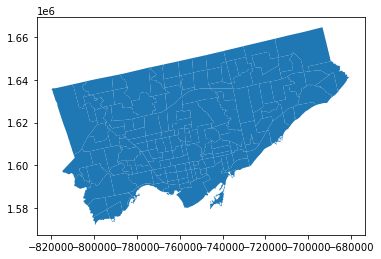

In [197]:
# Transfrorm the CRS to EPSG 2234
tor_shp = tor_shp.to_crs("EPSG:2234")
tor_shp.plot()

## <a id='Task 2'>Task 6 <a/>
Let's create the weight matrix using Queen's contiguity. You have learned this previously, and we will need this again for GWR and MGWR.

In [275]:
# Calculating neighbours based on the Queen's contiguity
wq = Queen.from_dataframe(tor_shp)
wq

Let's go on and continue constructing our model.

In [274]:
# Building the Geographically Weighted Regression Model
model = mgwr.gwr.GWR(g_coords, # a collection of n sets of x and y coordinates
                     g_y, # dependent variable
                     g_X, # independent variables
                     bw.bw[0]) # bandwidth value  ( we use N nearest neighbours)

AttributeError: 'Sel_BW' object has no attribute 'bw'

In [222]:
dir(OLSResults)

NameError: name 'OLSResults' is not defined

In [221]:
# Fit the model with particular estimations 
results = model.fit()
results.summary()

AttributeError: 'OLSResults' object has no attribute 'fit'

## <a id='Task 2'>Task 7 <a/>

**How good is the model? Can you compare the two models?**

The results summary contains the summary statistic of both the global model (using OLS) - top part; and the Geographically Weighted Regression results - bottom part.

To check the goodness of fit of the model, we can compare these values:

- The residual sum of squares (RSS), indicating unexplained variations, **lower RSS indicates better model fit**
- corrected Akaike Information Criterion (AICc): representing the relative amount of lost information in the model by considering both the risk of overfitting and underfitting, **lower AICc indicates better model fit**
- The adjusted $R^2$ indicates the level of model variance that can be captured by the model, **higher adjusted $R^2$ indicates better model fit**

In [52]:
# We can check the shape of our local parameters array
print(results.params.shape)

(166, 5)


In [53]:
type(results.params)

numpy.ndarray

From our GWR model, we can get the local estimates as well as local R2.

It is important in GWR that we **only include statistically significant estimates** (in our case, we will assign 95% confidence intervals, thus the p-value of our local estimates need to be lower than 0.05.

Luckily, mgwr package has a method to extract only a filtered set of significant local estimates by assigning 0 for local estimates that are not significant using `filter_tval`.

In [54]:
# Filtering only significant result at 0.05 (95% confidence interval)
filtered_estimates = results.filter_tvals(alpha=.05)
filtered_estimates

# Can you check the estimates using 99% and 90% confidence interval
filtered_estimates90 = results.filter_tvals(alpha=.1)
filtered_estimates99 = results.filter_tvals(alpha=.01)

### 6.4 Visualising the GWR results

To make it easier on reading the results of our model, we will build a new dataframe containing the information of the model's parameter estimates and local R2 in Connecticut Towns.

In [55]:
# Convert arrays to data frame
data_params = pd.DataFrame(filtered_estimates)
data_localR2 = pd.DataFrame(results.localR2)

In [56]:
# Create the new dataframe
df1=pd.DataFrame(gwr_data["Town"])
df2 = df1.assign(intercept=data_params[0],
                 Med_income_estimate=data_params[1],
                 Med_rent_estimate=data_params[2],
                 total_stop_search_estimate=data_params[3],
                 total_ss_arrests=data_params[4],
                 localR2=data_localR2[0])
df2.columns
df2

,Town,intercept,Med_income_estimate,Med_rent_estimate,total_stop_search_estimate,total_ss_arrests,localR2
0,Andover,0.000000,0.0,0.000000,0.0,0.000000,-0.786738
1,Ansonia,0.000000,0.0,0.000000,0.0,0.000000,0.596445
2,Ashford,0.000000,0.0,0.000000,0.0,0.000000,-0.724248
3,Avon,0.000000,0.0,0.000000,0.0,4.480764,0.595410
4,Barkhamsted,3.127313,0.0,0.000000,0.0,6.354661,0.773314
...,...,...,...,...,...,...,...
161,Windsor,0.000000,0.0,0.000000,0.0,4.072186,0.611670
162,Windsor Locks,0.000000,0.0,2.641024,0.0,0.000000,0.229291
163,Wolcott,0.000000,0.0,0.000000,0.0,0.000000,0.418441
164,Woodbridge,0.000000,0.0,0.000000,0.0,0.000000,0.024386


We can merge the results of our MGWR model and our shapefile using merge function

In [57]:
# Merge our shapefile with the model's results
ct_shp = ct_shp.merge(df2, left_on='NAME10', right_on='Town')
ct_shp.head()

,STATEFP10,COUNTYFP10,COUSUBFP10,COUSUBNS10,GEOID10,NAME10,NAMELSAD10,LSAD10,CLASSFP10,MTFCC10,...,GEOID_AFF2,GEOID_AFF1,geometry,Town,intercept,Med_income_estimate,Med_rent_estimate,total_stop_search_estimate,total_ss_arrests,localR2
0,09,001,04720,00213390,0900104720,Bethel,Bethel town,43,T1,G4040,...,0600000US0900104720,06000US0900104720,"POLYGON ((812330.489 695326.462, 812189.132 69...",Bethel,0.0,0.0,0.0,0.0,0.0,0.520187
1,09,001,08070,00213396,0900108070,Bridgeport,Bridgeport town,43,T5,G4040,...,0600000US0900108070,06000US0900108070,"POLYGON ((866858.577 613200.728, 866795.792 61...",Bridgeport,0.0,0.0,0.0,0.0,0.0,0.734032
2,09,001,08980,00213399,0900108980,Brookfield,Brookfield town,43,T1,G4040,...,0600000US0900108980,06000US0900108980,"POLYGON ((815897.176 724656.319, 815621.979 72...",Brookfield,0.0,0.0,0.0,0.0,0.0,0.404112
3,09,001,18500,00213415,0900118500,Danbury,Danbury town,43,T5,G4040,...,0600000US0900118500,06000US0900118500,"POLYGON ((815302.227 727185.032, 815525.656 72...",Danbury,0.0,0.0,0.0,0.0,0.0,0.651629
4,09,001,18850,00213416,0900118850,Darien,Darien town,43,T1,G4040,...,0600000US0900118850,06000US0900118850,"POLYGON ((790671.058 585600.161, 790670.785 58...",Darien,0.0,0.0,0.0,0.0,0.0,0.519245


Let's visualise the GWR results

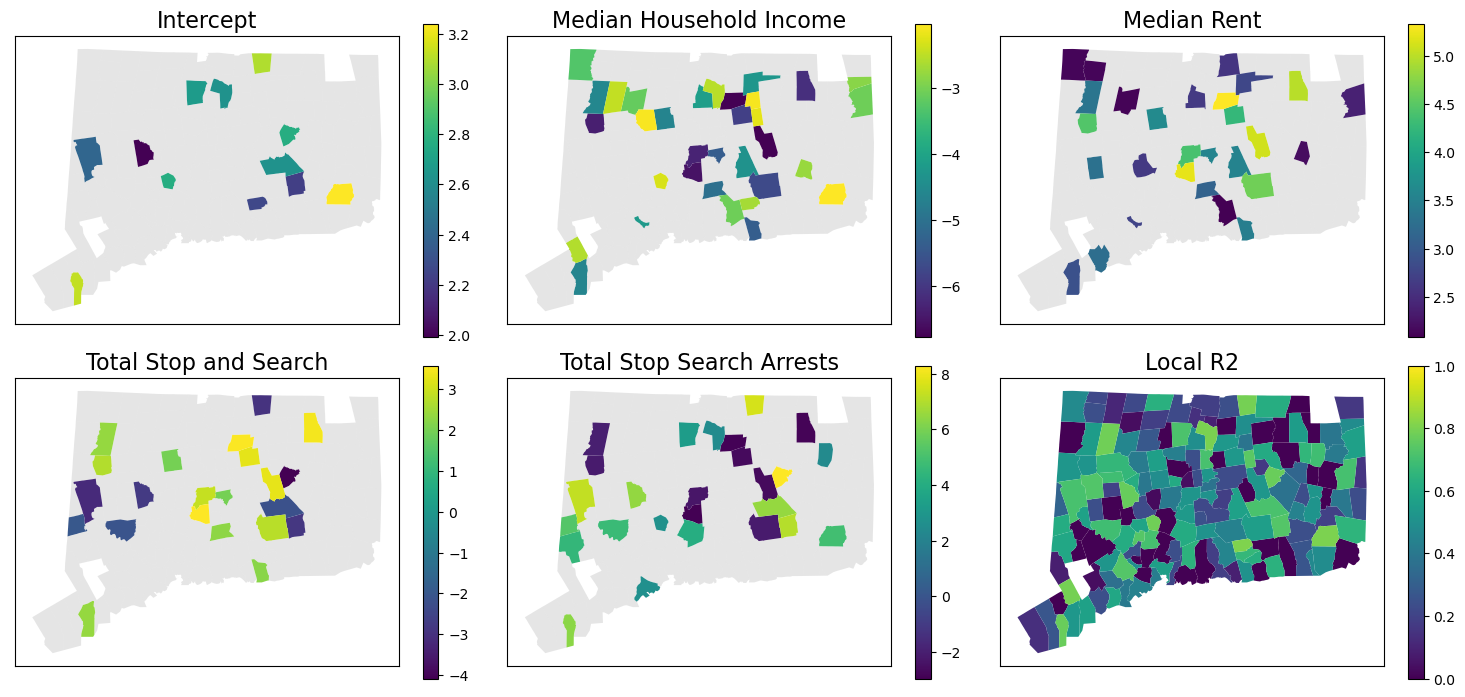

In [58]:
# First, let's create empty set of subplots with 2 rows and 3 columns
f,ax=plt.subplots(2,3,figsize=(15,7), subplot_kw=dict(aspect='equal'))
# Flatten them
ax = ax.flatten()
# Define the title of our plots
titles = ['Intercept','Median Household Income', 'Median Rent', 'Total Stop and Search', 'Total Stop Search Arrests']

# Here, we are creating loop for our parameter estimates 
for i,row in enumerate(filtered_estimates.T):
    # We want to plot all the non-significant estimates in grey
    ct_temp = ct_shp.assign(toplot=filtered_estimates.T[i])
    (ct_temp.query('toplot==0')
     .sort_values('toplot')
     .plot(color='grey',ax=ax[i],alpha=.2))
    # and assign colours only to the significant estimates
    (ct_temp.query('toplot!=0')
     .sort_values('toplot')
     .plot('toplot',
           cmap='viridis',
           ax=ax[i],
           legend=True))
    
    ax[i].set_title(titles[i], fontsize=16)
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
 
# For the last one, local R2, we can just map all of them regarding the significance

(ct_shp.assign(r2=results.localR2)
 .sort_values('r2')
 .plot('r2',
       ax=ax[-1],
       legend=True,
       vmin=0,
       vmax=1,
       cmap='viridis'))
    
ax[-1].set_xticklabels([])
ax[-1].set_yticklabels([])
ax[-1].set_xticks([])
ax[-1].set_yticks([])
    
ax[-1].set_title('Local R2', fontsize=16)
    
f.tight_layout()
    
plt.show()
    

### 6.5 Taking it further - Building MGWR Model
MGWR recasts GWR as a generalised additive model (GAM) and uses a back fitting algorithm. This refers to the iterative process of calibrating a series of GWR models based on the models' partial residuals until the MGWR model converges to a solution. In other words, the algorithm allows us to update each iteration process using an appropriate smoothing function by refining the partial residuals. Taylor Oshan (2018) argues that an MGWR needs to be initialised using a starting value (generally the optimum parameter estimates based on the GWR model) for faster model calibration. Here, we will be using MGWR library, as we have already define our coordinate, y and x, let's just reuse them.

In [59]:
#Prepare dataset inputs
g_y = gwr_data['Crime_index'].values.reshape((-1,1))
g_X = gwr_data[['Median_household_income', 'Median_rent', 'n_arrests']].values
u = gwr_data['X']
v = gwr_data['Y']
g_coords = list(zip(u,v))

# Standardised our data to have mean of 0 and standard deviation of 1
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [60]:
#Calibrate GWR model

gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit()

44.0


In [61]:
#Calibrate MGWR model

mgwr_selector = Sel_BW(g_coords, g_y, g_X, multi=True)
mgwr_bw = mgwr_selector.search(multi_bw_min=[2])
print(mgwr_bw)
mgwr_results = MGWR(g_coords, g_y, g_X, mgwr_selector).fit()

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[103.  20. 107.  39.]


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

## <a id='Task 2'>Task 8 <a/>
- Can you see the summary of both the gwr and mgwr results?
- Filter only significant mgwr result at 0.05 (95% confidence interval)

In [62]:
# show gwr results here
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 166
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            144.206
Log-likelihood:                                                    -223.862
AIC:                                                                455.724
AICc:                                                               458.099
BIC:                                                               -683.936
R2:                                                                   0.131
Adj. R2:                                                              0.115

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [63]:
# show mgwr result here
mgwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 166
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            144.206
Log-likelihood:                                                    -223.862
AIC:                                                                455.724
AICc:                                                               458.099
BIC:                                                               -683.936
R2:                                                                   0.131
Adj. R2:                                                              0.115

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [64]:
# Filtering only significant result at 0.05 (95% confidence interval)
mgwr_filtered_estimates = mgwr_results.filter_tvals(alpha=.05)
mgwr_filtered_estimates

array([[  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   5.00486808,   0.        ,   6.4327361 ],
       [  0.        ,   0.        ,   0.        ,  11.25685928],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   2.22093896,   0.        ,   6.15929202],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   2.28931035,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0

In [65]:
#Add GWR parameters to GeoDataframe
ct_shp['gwr_intercept'] = gwr_results.params[:,0]
ct_shp['gwr_med_income'] = gwr_results.params[:,1]
ct_shp['gwr_med_rent'] = gwr_results.params[:,2]
ct_shp['gwr_totalSS_arrest'] = gwr_results.params[:,3]

#Obtain t-vals filtered based on multiple testing correction
gwr_filtered_t = gwr_results.filter_tvals()

In [66]:
#Add MGWR parameters to GeoDataframe
ct_shp['mgwr_intercept'] = mgwr_results.params[:,0]
ct_shp['mgwr_med_income'] = mgwr_results.params[:,1]
ct_shp['gwr_med_rent'] = gwr_results.params[:,2]
ct_shp['mgwr_totalSS_arrest'] = mgwr_results.params[:,3]

#Obtain t-vals filtered based on multiple testing correction
mgwr_filtered_t = mgwr_results.filter_tvals()

In [67]:
ct_shp

,STATEFP10,COUNTYFP10,COUSUBFP10,COUSUBNS10,GEOID10,NAME10,NAMELSAD10,LSAD10,CLASSFP10,MTFCC10,...,total_stop_search_estimate,total_ss_arrests,localR2,gwr_intercept,gwr_med_income,gwr_med_rent,gwr_totalSS_arrest,mgwr_intercept,mgwr_med_income,mgwr_totalSS_arrest
0,09,001,04720,00213390,0900104720,Bethel,Bethel town,43,T1,G4040,...,0.000000,0.000000,0.520187,-0.190334,-0.061918,0.062476,0.001816,-0.115376,-0.114305,-0.006356
1,09,001,08070,00213396,0900108070,Bridgeport,Bridgeport town,43,T5,G4040,...,0.000000,0.000000,0.734032,-0.100655,-0.089407,-0.003986,0.202804,-0.101255,-0.023119,0.127613
2,09,001,08980,00213399,0900108980,Brookfield,Brookfield town,43,T1,G4040,...,0.000000,0.000000,0.404112,-0.154957,-0.111581,0.258484,0.047646,-0.116857,-0.046520,0.086700
3,09,001,18500,00213415,0900118500,Danbury,Danbury town,43,T5,G4040,...,0.000000,0.000000,0.651629,0.291609,0.189323,0.037127,0.773916,0.064299,1.050640,0.766827
4,09,001,18850,00213416,0900118850,Darien,Darien town,43,T1,G4040,...,0.000000,0.000000,0.519245,0.593220,-0.188450,0.037908,1.176127,0.116337,-0.171340,1.355571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,09,009,78740,00213522,0900978740,Wallingford,Wallingford town,43,T1,G4040,...,0.000000,0.000000,-0.140054,0.034975,0.102793,0.015031,0.521564,0.031000,0.114045,0.454340
162,09,009,80070,00213525,0900980070,Waterbury,Waterbury town,43,T5,G4040,...,3.585904,-2.966502,0.537333,-0.016545,0.093453,0.971071,-0.021136,-0.022108,0.097117,0.097247
163,09,009,82870,00213530,0900982870,West Haven,West Haven town,43,T5,G4040,...,0.000000,0.000000,0.561584,-0.139294,-0.089909,0.037357,0.107215,-0.099825,-0.028260,0.086649
164,09,009,87560,00213538,0900987560,Wolcott,Wolcott town,43,T1,G4040,...,0.000000,0.000000,0.418441,-0.120256,-0.151714,0.010456,-0.035025,-0.049178,-0.133077,-0.043733


## <a id='Task 2'>Task 9 <a/>
Can you visualise the MGWR results? Just follow what we did for GWR.
Please note that MGWR doesn't have the capability to show local R2 yet.

/Users/k1929112/opt/anaconda3/envs/sds2022-draft/lib/python3.9/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


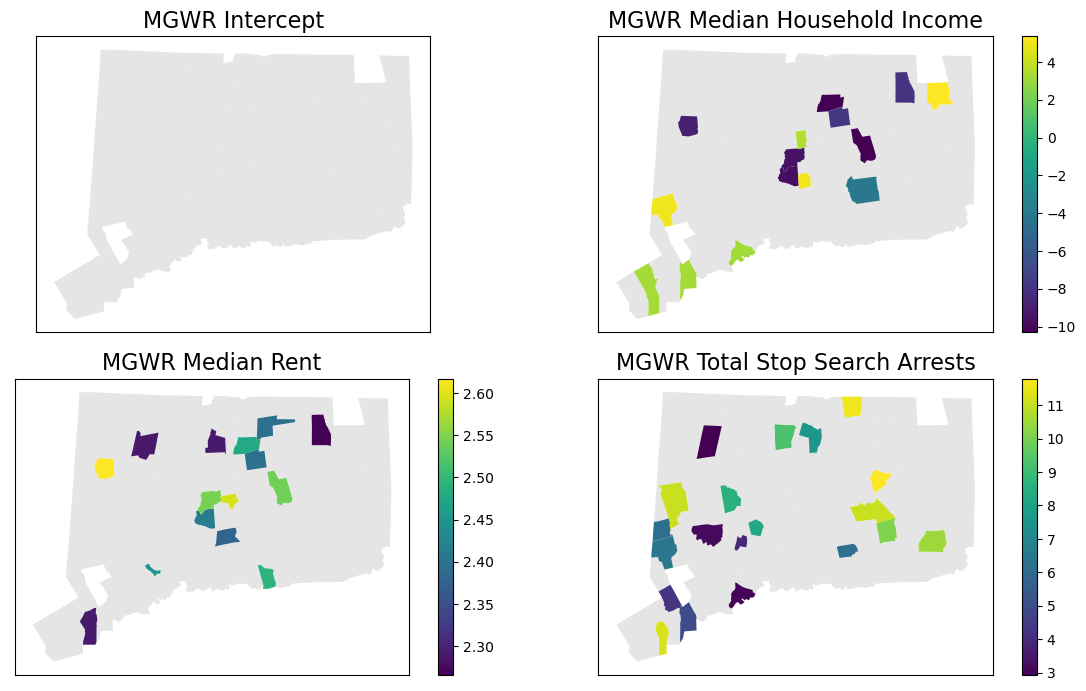

In [68]:
# First, let's create empty set of subplots with 2 rows and 2 columns
f,ax=plt.subplots(2,2, figsize=(12,7), subplot_kw=dict(aspect='equal'))
# Flatten them
ax = ax.flatten()
# Define the title of our plots
titles = ['MGWR Intercept','MGWR Median Household Income', 'MGWR Median Rent', 'MGWR Total Stop Search Arrests']

# Here, we are creating loop for our parameter estimates 
for i,row in enumerate(mgwr_filtered_t.T):
    # We want to plot all the non-significant estimates in grey
    ct_temp = ct_shp.assign(toplot=mgwr_filtered_t.T[i])
    (ct_temp.query('toplot==0')
     .sort_values('toplot')
     .plot(color='grey',ax=ax[i],alpha=.2))
    # and assign colours only to the significant estimates
    (ct_temp.query('toplot!=0')
     .sort_values('toplot')
     .plot('toplot',
           cmap='viridis',
           ax=ax[i],
           legend=True))
    
    ax[i].set_title(titles[i], fontsize=16)
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
ax[-1].set_xticklabels([])
ax[-1].set_yticklabels([])
ax[-1].set_xticks([])
ax[-1].set_yticks([])
    
f.tight_layout()
    
plt.show()
    

## <a id='Task 2'>Task 10 <a/>
Can you see the differences between GWR and MGWR results? Discuss with your group:
    - Why the intercept and Total Stop and Search empty?
    - Can you compare with the bandwidth for each variable?

## Takeaways

Spatial heterogeneity is often lost in OLS, thus a more robust model is needed. The GWR model often improves models performance in spatial cases, by allowing local variations to be captured. 

Now, what is the difference between spatial regressions (Spatial Lag or Error Model) you have learned in level 5 versus GWR? Spatial regression would provide you with **global models** while GWR and MGWR are **local models**. So, if what you are aiming for is the local variation, then GWR/MGWR is your answer!

## Congratulation in completing this practical!! 


## Contributors:
The following individuals have contributed to these teaching materials: Dr Zahratu Shabrina

## References

Arribas-bel, Dani. Geographic Data Science with PySAL and the pydata stack. Available at  http://darribas.org/gds_scipy16/ipynb_md/05_spatial_dynamics.html

Brunsdon, C., Fotheringham, A. S., & Charlton, M. E. (1996). Geographically weighted regression: a method for exploring spatial nonstationarity. *Geographical analysis*, 28(4), 281-298.

Fotheringham, A. S., Brunsdon, C., & Charlton, M. (2003). Geographically weighted regression: the analysis of spatially varying relationships. John Wiley & Sons.

Triest, P. Open Source Tutorial For Analyzing & Visualizing 60 Million Police Stops Using Python. https://github.com/triestpa/Police-Analysis-Python

https://methods.sagepub.com/dataset/howtoguide/geographically-weighted-regression-berlin-districts-2018-python

https://github.com/pysal/mgwr/blob/master/notebooks/MGWR_Georgia_example.ipynb

## License
These teaching materials are licensed under a mix of [The MIT License](https://opensource.org/licenses/mit-license.php) and the [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 license](https://creativecommons.org/licenses/by-nc-sa/4.0/).